In [3]:
from src.tools import run_hmmer
from utils import * 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np
import os

In [4]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)

In [5]:
# run_hmmer(overwrite=True)

In [6]:
# If the theory about hydroxylation is correct, then it's the lysine residue which is hydroxylated. 
# I think I need a refresher on the paper, but I think only lysine could be hydroxylated. 
# JmjC domain-containing proteins also play a role in histone demathylation (archaea do seem to have histones)

# https://www.ebi.ac.uk/interpro/entry/InterPro/IPR003349/
# https://pmc.ncbi.nlm.nih.gov/articles/PMC3991326/#fig4
# https://www.uniprot.org/uniprotkb/Q9H9V9/entry 

# How conserved is the K residue in the NIKS domain?

In [7]:
query_names = ['JmjC_2', 'JmjC', 'PTHR12480.orig.30.pir', 'PTHR12480.SF6.pir'] # Only load possible hits for JmjC domain-containing proteins. 
if not os.path.exists('../data/hmmer_jmjc.csv'):
    # With the best_hit_only parameter, there should only be one entry per sequence. 
    hmmer_df = hmmer_load(query_names=query_names, best_hit_only=True)
    hmmer_df.to_csv('../data/hmmer_jmjc.csv')
    
hmmer_df = pd.read_csv('../data/hmmer_jmjc.csv')
# hmmer_df = hmmer_df.set_index('target_name')
hmmer_df['has_pyl'] = hmmer_df.genome_id.map(arf1_df.set_index('genome_id').has_pyl)
print('Hits in hmmer_df:', ', '.join(hmmer_df.query_name.unique()))

Hits in hmmer_df: JmjC_2, PTHR12480.orig.30.pir, JmjC, PTHR12480.SF6.pir


In [8]:
def get_jmjc_data(hmmer_df:pd.DataFrame, genome_ids=None, data_dir:str='../data/prodigal', query_names:list=query_names):
    if genome_ids is None:
        genome_ids = hmmer_df.genome_id.unique()
    hmmer_df = hmmer_df[hmmer_df.genome_id.isin(genome_ids) & hmmer_df.query_name.isin(query_names)].copy()
    hmmer_df = hmmer_df.set_index('target_name')

    jmjc_df = list()
    for genome_id, df in tqdm(list(hmmer_df.groupby('genome_id')), desc='get_jmjc_data'):
        fasta_df = FASTAFile.from_fasta(os.path.join(data_dir, f'{genome_id}.fa')).to_df()
        fasta_df['length'] = fasta_df.seq.apply(len)
        # Remove all sequences which have long runs of unknown residues or run off the end of a contig.
        fasta_df['partial'] = ~fasta_df.description.str.contains('partial=00') | fasta_df.seq.str.contains('X{5,}', regex=True) 
        fasta_df = fasta_df[fasta_df.index.isin(df.index)]
        fasta_df = fasta_df.merge(df, left_index=True, right_index=True) # Add the HMMer data. 
        jmjc_df.append(fasta_df)

    return pd.concat(jmjc_df)

# jmjc_df = get_jmjc_data(hmmer_df)
# jmjc_df.to_csv('../data/jmjc.csv')
jmjc_df = pd.read_csv('../data/jmjc.csv', index_col=0)
FASTAFile().from_df(jmjc_df).write('../data/jmjc.fa')

print('Num. JmjC hits:', len(jmjc_df))

Num. JmjC hits: 3743


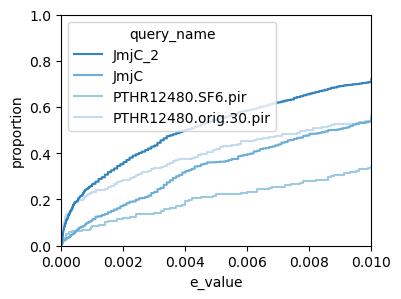

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.ecdfplot(jmjc_df, x='e_value', ax=ax, hue='query_name', palette='tab20c')
ax.set_xlim(xmax=1e-2, xmin=0)
ax.set_ylabel('proportion')
plt.show()

In [13]:
jmjc_df[jmjc_df.query_name == 'PTHR12480.SF6.pir']

,description,seq,length,partial,Unnamed: 0,query_name,e_value,query_coords,target_coords,envelope_coords,target_length,query_length,n_hits,genome_id,max_e_value,has_pyl
QHBN01000194.1_24,# 16771 # 17016 # -1 # ID=194_24;partial=00;st...,MTIFVGSPSLVHDTFTIEPGEIVFVPQGYLHEFNNISNEEAKFVLV...,82,False,3,PTHR12480.SF6.pir,1.600000e-04,241..263,15..37,7..68,82,421,1,GCA_003176995.1,inf,False
WJXE01000108.1_1,# 128 # 1381 # -1 # ID=11_1;partial=00;start_t...,MSIHPENNSDSDGKISRRTFIKYVGAAGAVFTLSSLLPFNKAFAAG...,418,False,3,PTHR12480.SF6.pir,1.400000e-04,"241..263,246..262","156..178,339..355","131..216,332..386",418,421,2,GCA_009665115.1,inf,NaN
JAATVT010000079.1_2,# 1139 # 2164 # -1 # ID=14_2;partial=00;start_...,MHSAHTFDIKSTKSQAICNGGSRTIANSDNFPILRGMATYSLKLDR...,342,False,0,PTHR12480.SF6.pir,2.400000e-04,"239..270,244..263","81..117,262..281","60..119,248..287",342,421,2,GCA_014523685.1,inf,NaN
JAICVG010000165.1_2,# 618 # 1703 # -1 # ID=96_2;partial=00;start_t...,MVLSYRYLEIDRYVLIKRKYMSSIHTFNLEAIKPQAVCNGGTRSMA...,362,False,3,PTHR12480.SF6.pir,3.500000e-08,"242..264,243..264","104..126,281..302","92..147,255..315",362,421,2,GCA_025935445.1,inf,NaN
JAUWOO010000039.1_9,# 6908 # 7660 # 1 # ID=4_9;partial=00;start_ty...,MNIKKLLAVGIILLFIGITYAPGIIAYNSSLVNTIYVDDDNTEGPW...,251,False,2,PTHR12480.SF6.pir,9.100000e-05,243..273,64..144,31..168,251,421,1,GCA_030612095.1,inf,NaN
DATKOK010000061.1_8,# 6479 # 6922 # 1 # ID=61_8;partial=00;start_t...,MVGRKLFVNEDEVPMKRVQRVGSSGYGYIRTLIDPETIGSANAVLG...,148,False,2,PTHR12480.SF6.pir,1.600000e-04,200..264,49..115,40..146,148,421,1,GCA_035524675.1,inf,False
DATDNG010000419.1_4,# 1002 # 2024 # -1 # ID=419_4;partial=00;start...,MSSGHTFNLEAIKPQAVRIGGSRAMANQDNFSILKGMALYSLRLDN...,341,False,4,PTHR12480.SF6.pir,5.200000e-07,"242..270,244..263","84..117,261..280","72..121,245..294",341,421,2,GCA_036518375.1,inf,False
DATDHY010000181.1_4,# 3561 # 4832 # 1 # ID=181_4;partial=00;start_...,MYKSNQDKSNSEDSKISRKDFLKYVGATGAIIGLSCLPFKILAQSV...,424,False,4,PTHR12480.SF6.pir,2.600000e-06,"240..265,243..263","156..214,342..362","119..237,331..408",424,421,2,GCA_036521355.1,inf,NaN
DATBFR010000094.1_36,# 27306 # 28562 # -1 # ID=94_36;partial=00;sta...,MRGKILEALNQDKKDPSEIEFKKEKVTRRHFLKLVGAAGTLATLAT...,419,False,6,PTHR12480.SF6.pir,6.200000e-05,"239..264,244..261","157..182,338..355","131..202,325..361",419,421,2,GCA_036558405.1,inf,NaN
JBDUES010000166.1_1,# 184 # 1149 # -1 # ID=166_1;partial=00;start_...,MVTYLLRLKNGGVREPHWHPNAAELTYCVSGRAEMTIYPSNADADS...,322,False,2,PTHR12480.SF6.pir,1.200000e-05,"240..264,244..263","56..80,241..260","21..133,234..280",322,421,2,GCA_040297625.1,inf,NaN


In [11]:
max_e_value = 0.00025 # Set so that I can run BLAST normally. 
jmjc_df = jmjc_df[jmjc_df.e_value < max_e_value].copy()
print(f'Num. HMM hits which meet the threshold {max_e_value}:', len(jmjc_df))
jmjc_df = jmjc_df[~jmjc_df.partial].copy()

jmjc_df.to_csv('../data/jmjc_cleaned.csv')
FASTAFile().from_df(jmjc_df).write('../data/jmjc_cleaned.fa')

Num. HMM hits which meet the threshold 0.00025: 426


In [12]:
# The Jmjd4 protein is about 400 residues in length (human).